# <center> Astro-inference from A to Z <center>

## Step 1: What are your GWB hyperparameters (binary evolution params)?

In [1]:
import numpy as np
import json, glob, pickle, os
from scipy.stats import qmc
import corner
import random
from scipy.stats.distributions import norm, uniform

import matplotlib.pyplot as plt
hist_settings = dict(
    bins = 40,
    histtype = 'step',
    lw = 3,
    density = True
)
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
plt.style.use('default')
def figsize(scale, wc = 1, hc = 1):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [wc * fig_width,hc * fig_height]
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {#'backend': 'pdf',
        'axes.labelsize': 12,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        "xtick.top": True,
        "ytick.right": True,
        "xtick.minor.visible": True,
        "xtick.major.top": True, 
        "xtick.minor.top": True,
        "ytick.minor.visible": True, 
        "ytick.major.right": True, 
        "ytick.minor.right": True,
        "ytick.direction": "in",
        "xtick.direction": "in",
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        "text.usetex": True,
        #'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.5, 1, 1)}
plt.rcParams.update(params)

In [3]:
# These are the 'phenom' binary evolution parameters' distributions
[
    'Uniformm(0.1, 11)',
    'Normal(-2.56, 0.4)',
    'Normal(10.9, 0.4)',
    'Normal(8.6, 0.2)',
    'Normal(0.32, 0.15)',
    'Uniform(-1.5, 0.0)'
]
n_astro_params = 6 # this could change depending on the model
crn_bins = 5 # the number of GWB frequency-bins

In [4]:
astro_draws = int(1e4) # number of draws from the distributions
sampler = qmc.LatinHypercube(d=6, strength=1).random(n=astro_draws)
sampler.shape

(10000, 6)

In [5]:
lhd = []
lhd.append(uniform(loc = 0.1, scale = 11 - 0.1).ppf(sampler[:, 0])) 
lhd.append(norm(loc=-2.56, scale=0.4).ppf(sampler[:, 1])) 
lhd.append(norm(loc=10.9, scale=0.4).ppf(sampler[:, 2])) 
lhd.append(norm(loc=8.6, scale=0.2).ppf(sampler[:, 3])) 
lhd.append(norm(loc=0.32, scale=0.15).ppf(sampler[:, 4])) 
lhd.append(uniform(loc = -1.5, scale = 1.5).ppf(sampler[:, 5]))
lhd = np.array(lhd).T
lhd.shape

(10000, 6)

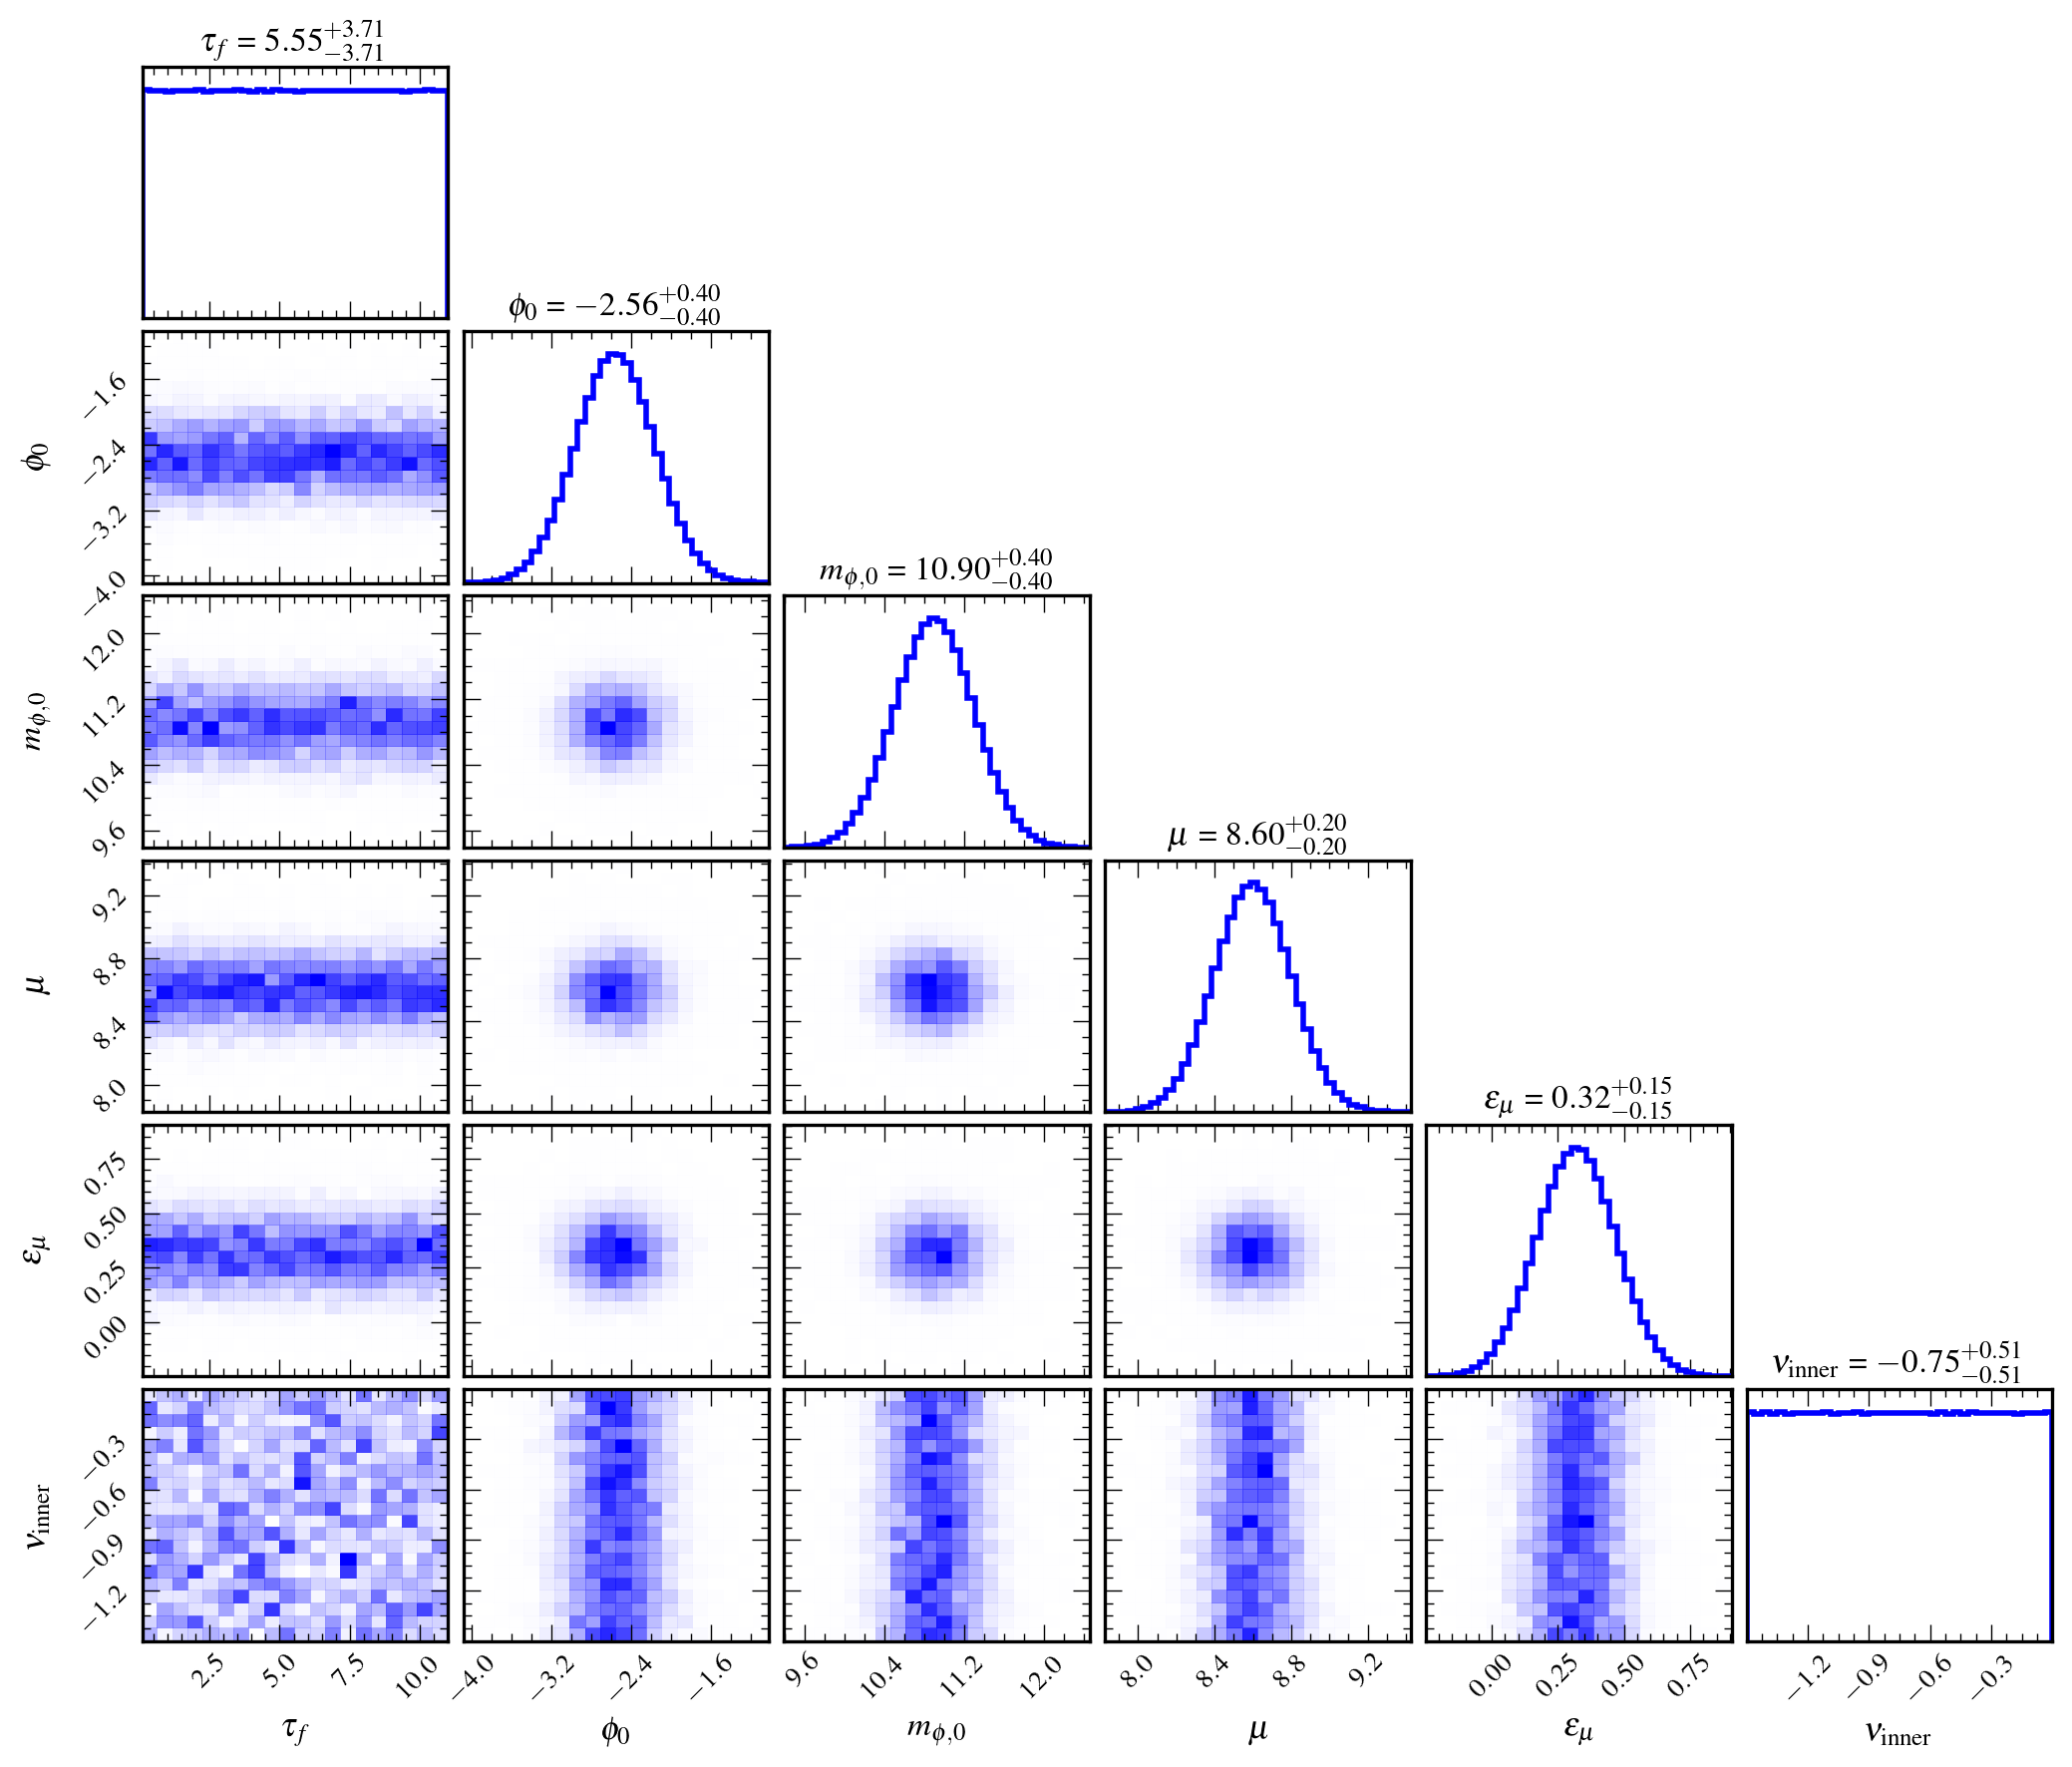

In [6]:
labels = [r'$\tau_f$', r'$\phi_{0}$', r'$m_{\phi,0}$', r'$\mu$', r'$\epsilon_{\mu}$', r'$\nu_{\rm{inner}}$']
fig = plt.figure(figsize=figsize(0.5, 3, 4))
corner.corner(lhd, color='blue', fig = fig, bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'linewidth':2}, 
                    contour_kwargs={'linewidths':.0001}, labels = labels,show_titles = True,plot_contours = False,
            truth_color = 'black', desity = True, plot_datapoints = False)
plt.show()

In [7]:
np.save('../test_astro_params.npy', lhd)

## Step 2: Ask holodeck for GWB spectrum

In [18]:
import numpy as np
from holodeck import sams, utils, hardening, host_relations
from holodeck.constants import MSOL, YR, PC, GYR
from holodeck.librarian.lib_tools import _Param_Space, PD_Uniform, PD_Normal
from joblib import Parallel, delayed
import os
from natsort import natsorted
import glob
from tqdm.auto import trange
from tqdm_joblib import tqdm_joblib

In [ ]:
def init_sam(sam_shape, params):
    gsmf = sams.GSMF_Schechter(
        phi0=params['gsmf_phi0_log10'],
        phiz=params['gsmf_phiz'],
        mchar0_log10=params['gsmf_mchar0_log10'],
        mcharz=params['gsmf_mcharz'],
        alpha0=params['gsmf_alpha0'],
        alphaz=params['gsmf_alphaz'],
    )
    gpf = sams.GPF_Power_Law(
        frac_norm_allq=params['gpf_frac_norm_allq'],
        malpha=params['gpf_malpha'],
        qgamma=params['gpf_qgamma'],
        zbeta=params['gpf_zbeta'],
        max_frac=params['gpf_max_frac'],
    )
    gmt = sams.GMT_Power_Law(
        time_norm=params['gmt_norm']*GYR,
        malpha=params['gmt_malpha'],
        qgamma=params['gmt_qgamma'],
        zbeta=params['gmt_zbeta'],
    )
    mmbulge = host_relations.MMBulge_KH2013(
        mamp_log10=params['mmb_mamp_log10'],
        mplaw=params['mmb_plaw'],
        scatter_dex=params['mmb_scatter_dex'],
    )

    sam = sams.Semi_Analytic_Model(
        gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge,
        shape=sam_shape,
    )
    return sam

def init_hard(sam, params):
    hard = hardening.Fixed_Time_2PL_SAM(
        sam,
        params['hard_time']*GYR,
        sepa_init=params['hard_sepa_init']*PC,
        rchar=params['hard_rchar']*PC,
        gamma_inner=params['hard_gamma_inner'],
        gamma_outer=params['hard_gamma_outer'],
    )
    return hard

SAM_SHAPE = (50, 50, 50)
NUM_REALS = int(1e4)    # Number of 'realizations' to generate
NUM_LOUDEST = 0   # Number of 'loudest' binaries to generate in each frequency bin
PTA_DUR_yr = 20
PTA_DUR = PTA_DUR_yr * YR
NUM_FREQS = 5
freqs = np.arange(1/PTA_DUR, (NUM_FREQS+ .001)/PTA_DUR, 1/PTA_DUR)
SAVEDIR = '../'
os.makedirs(SAVEDIR, exist_ok = True)


params = dict(
    hard_time=3.0,          #This will be varied
    hard_sepa_init=1e4,     
    hard_rchar=100.0,       
    hard_gamma_inner=-1.0, ##This will be varied
    hard_gamma_outer=+2.5,

    gsmf_phi0_log10=-2.77, ##This will be varied
    gsmf_phiz=-0.6,
    gsmf_mchar0_log10=11.24,##This will be varied
    gsmf_mcharz=0.11,
    gsmf_alpha0=-1.21,
    gsmf_alphaz=-0.03,

    gpf_frac_norm_allq=0.025,
    gpf_malpha=0.0,
    gpf_qgamma=0.0,
    gpf_zbeta=1.0,
    gpf_max_frac=1.0,

    gmt_norm=0.5,           
    gmt_malpha=0.0,
    gmt_qgamma=-1.0,      
    gmt_zbeta=-0.5,

    mmb_mamp_log10=8.69, ##This will be varied
    mmb_plaw=1.10,          
    mmb_scatter_dex=0.3, ##This will be varied
)

theta_master = np.load('../test_astro_params.npy', mmap_mode = 'r')
def doit(rr):
    
    theta = theta_master[rr] #randomly selected draws from the distributions
    params['hard_time'] = theta[0]
    params['gsmf_phi0_log10'] = theta[1]
    params['gsmf_mchar0_log10'] = theta[2]
    params['mmb_mamp_log10'] = theta[3]
    params['mmb_scatter_dex'] = theta[4]
    params['hard_gamma_inner'] = theta[5]

    sam = init_sam(sam_shape = SAM_SHAPE, params = params)
    hard = init_hard(sam, params)
    fobs_gw_cents, fobs_gw_edges = utils.pta_freqs(PTA_DUR, NUM_FREQS)
    hc_ss_ph = sam.gwb_new(fobs_gw_edges, hard=hard, realize=NUM_REALS)
    # hc_ss_ph, hc_bg_ph = sam.gwb(fobs_gw_edges, hard=hard, realize=NUM_REALS, loudest=NUM_LOUDEST)
    spectrum = 0.5 * np.log10(hc_ss_ph**2/(12*np.pi**2 * freqs[:, None]**3 * PTA_DUR))
    if np.isfinite(spectrum).all():
        np.save(SAVEDIR + f'/{rr}_{PTA_DUR_yr}yrs.npy', spectrum)

In [17]:
# Run them all in parallel
astro_draws_to_do = 20 #theta_master.shape[0]
with tqdm_joblib(desc="Processing", total=astro_draws_to_do ) as progress_bar:
    Parallel(n_jobs=20)(delayed(doit)(i) for i in range(astro_draws_to_do ))

Processing:   0%|          | 0/20 [00:00<?, ?it/s]

11:05:04 INFO : Galaxy pair-fraction provided, using galaxy pair-fraction and merger-time. [sam.py:__init__]
11:05:04 INFO : Galaxy pair-fraction provided, using galaxy pair-fraction and merger-time. [sam.py:__init__]
11:05:04 INFO : Galaxy pair-fraction provided, using galaxy pair-fraction and merger-time. [sam.py:__init__]
11:05:04 INFO : Galaxy pair-fraction provided, using galaxy pair-fraction and merger-time. [sam.py:__init__]
11:05:04 INFO : Galaxy pair-fraction provided, using galaxy pair-fraction and merger-time. [sam.py:__init__]
11:05:04 INFO : Galaxy pair-fraction provided, using galaxy pair-fraction and merger-time. [sam.py:__init__]
11:05:04 INFO : Galaxy pair-fraction provided, using galaxy pair-fraction and merger-time. [sam.py:__init__]
11:05:05 INFO : Galaxy pair-fraction provided, using galaxy pair-fraction and merger-time. [sam.py:__init__]
11:05:05 INFO : Galaxy pair-fraction provided, using galaxy pair-fraction and merger-time. [sam.py:__init__]
11:05:05 INFO : Gal

## Step 3: Prepare the data

In [21]:
paths = natsorted(glob.glob(SAVEDIR + f'/*_{PTA_DUR_yr}yrs.npy'))
assert paths
print(f'The total pop samples is {len(paths)}')

chain = np.lib.format.open_memmap(SAVEDIR + f'/gwb_spectrum_samples_{PTA_DUR_yr}yrs.npy', 
                    mode='w+', 
                    dtype='float64', 
                    shape=(len(paths), NUM_REALS , NUM_FREQS), 
                    fortran_order=False)

for idx in trange(len(paths)):
    chain[idx] = np.load(paths[idx]).T

The total pop samples is 20


  0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
chain[-1]

memmap([[-6.54595174, -7.10561871, -7.495954  , -7.83381402, -8.10748723],
        [-6.51859747, -7.11007446, -7.46073114, -7.67670831, -8.04397059],
        [-6.4932713 , -7.13464223, -7.58059427, -7.84611417, -8.16624649],
        ...,
        [-6.53081403, -7.16512408, -7.56590406, -7.87659483, -7.82587226],
        [-6.52349783, -7.16401068, -7.61358547, -7.71285889, -7.76594564],
        [-6.50993744, -7.16475304, -7.5265239 , -7.45630613, -8.04265202]])

In [32]:
gwb_data = np.load(SAVEDIR + f'/gwb_spectrum_samples_{PTA_DUR_yr}yrs.npy', mmap_mode='r')
# make sure the right samples are loaded. remove ':gwb_data.shape[0]' if needed
par_data = np.load('../test_astro_params.npy', mmap_mode = 'r')[:gwb_data.shape[0]]

n_real = gwb_data.shape[1]
n_samp = gwb_data.shape[0]
n_pars = par_data.shape[-1]

par_data = np.broadcast_to(par_data, (n_real, n_samp, n_pars)).transpose((1, 2, 0))
assert np.all(par_data[:, :, 100] == par_data[:, :, 89])

## The first axis is samples, the second is realization
par_data = par_data.transpose((0, 2, 1))
## The third axis combines `gwb_freq` params with other `params`. This is just a matter of organization!
chain = np.concatenate((par_data, gwb_data), axis = 2)

# bad_samp = np.load(f'/data/taylor_group/Nima/pandora/holodeck/hope/helper/nimsim_lib_gwb_{PTA_DUR_yr}yrs_{NUM_FREQS}bins_bad_samples_aggressive.npy')
# chain = np.delete(chain, bad_samp, axis = 0)
assert chain.all()

## Some things that we need to know about the library...
## Perform manual linear transformation of all the parameters (gwb + astro) to `[-B = -5, B = 5]`. The specific choice of `B` should not matter.
B = 5
min = np.min(chain, axis = 0).min(axis = 0)
max = np.max(chain, axis = 0).max(axis = 0)
mean = (max + min) / 2
half_range = (max - min) / 2
chain = B * (chain - mean) / half_range

np.save(SAVEDIR + f'/gwb_spectrum_samples_{PTA_DUR_yr}yrs_normalized.npy', chain[..., n_pars:])
np.save(SAVEDIR + f'/ast_spectrum_samples_{PTA_DUR_yr}yrs_normalized.npy', chain[:, 0, :n_pars])
np.savez_compressed(SAVEDIR + f'/gwb_spectrum_samples_{PTA_DUR_yr}yrs_mapping_data.npy', 
                B = B, mean = mean, half_range = half_range)

## Step 4: Normalizing Flows Training

In [1]:
import numpy as np
import random
import torch
import zuko
import os
import matplotlib.pyplot as plt
import corner
from tqdm.auto import trange
import cloudpickle as cpickle
import itertools
torch.set_default_dtype(torch.float64)

In [2]:
SAVEDIR = '../'
PTA_DUR_yr = 20
NUM_FREQS = 5
n_pars = 6 # number of astro params


chain_rho = np.load(SAVEDIR + f'/gwb_spectrum_samples_{PTA_DUR_yr}yrs_normalized.npy', mmap_mode = 'r')
chain_ast = np.load(SAVEDIR + f'/ast_spectrum_samples_{PTA_DUR_yr}yrs_normalized.npy', mmap_mode = 'r')

total_sample_size_data = chain_rho.shape[1]
total_sample_size_cont = chain_ast.shape[0]

data = torch.tensor(chain_rho.reshape(total_sample_size_data * total_sample_size_cont, NUM_FREQS), device = 'cuda')
# There are more memory efficient ways to do this, but this is the simplest way to do it.
# The context is the astro params, which are repeated for each gwb spectrum sample in the data.
# This is a bit memory inefficient, but it works for small datasets.
# If you have a large dataset, you might want to use a more memory efficient way.
contx = torch.tensor(np.repeat(chain_ast[:, None], total_sample_size_data, axis = 1).reshape(data.shape[0], n_pars), device = 'cuda')

# Define the number of features and context features
num_features = data.shape[-1]
context_features = contx.shape[-1]

In [3]:
# Below are the tuning parameters for the normalizing flows. You should try all of them to see which one works best for your data.
# all_pos = list(itertools.product([512, 256, 128, 64], [3e-3, 1e-3, 1e-4], [[512] * 2, [512] * 4, [512] * 6]))
all_pos = list(itertools.product([512], [1e-4], [[512] * 8]))

In [7]:
def doit(idx):
    one_pos = all_pos[idx]
    # Initialize the Neural Spline Flow
    flow = zuko.flows.spline.NSF(
        num_features,
        context_features,
        bins=8,  # Number of bins for the spline
        passes=2,  # Number of passes (2 for coupling)
        hidden_features = one_pos[-1]
    ).cuda()

    # Train the flow
    batch_size = one_pos[0]
    total_size = data.shape[0]

    print(data.shape)
    print(contx.shape)
    optimizer = torch.optim.Adam(flow.parameters(), lr=one_pos[1])

    for epoch in trange(int(1e4)): ## do this for int(1e5)
        optimizer.zero_grad()

        # rand_sample = random.randint(0, chain_ast.shape[1] - 1)
        rand_sample = random.sample(range(total_size), k = batch_size)

        # Obtain the distribution from the flow
        dist = flow(contx[rand_sample])
        # Compute the negative log-likelihood
        loss = -dist.log_prob(data[rand_sample]).mean()
        loss.backward()
        optimizer.step()
        if epoch % 5000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    torch.save([flow], SAVEDIR + f"/zuko_flow.pkl")

for _ in range(1):
    doit(_)

torch.Size([200000, 5])
torch.Size([200000, 6])


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0, Loss: 12.612863359532053
Epoch 5000, Loss: -1.059519759042197


## Step 5: Astro-inference

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jar
jax.config.update("jax_enable_x64", True)
import itertools

import numpy as np
from scipy.stats import norm
from scipy.stats import halfnorm

from pandora import models, GWBFunctions
from pandora import utils as putils
from pandora import LikelihoodCalculator as LC
from pandora import nf_dist
from joblib import Parallel, delayed

from enterprise_extensions.model_utils import get_tspan
from enterprise_extensions.models import model_general
from enterprise_extensions import blocks
from enterprise.signals import signal_base, gp_signals
import scipy.linalg as sl

import pickle, json, os, corner, glob, random, copy, time, inspect, math, sys
from natsort import natsorted
from tqdm import tqdm
import torch
torch.set_default_dtype(torch.float64)
import ray

Optional mpi4py package is not installed.  MPI support is not available.


In [5]:
crn_bins = 5
gwb_freq_bins = crn_bins

n_pars = 6
Tspan = 20 * 365.25 * 86400
freqs = np.arange(1/Tspan, (crn_bins + .001)/Tspan, 1/Tspan)

aux_info = np.load('../gwb_spectrum_samples_20yrs_mapping_data.npy.npz')
B = aux_info['B']
mean = aux_info['mean']
half_range = aux_info['half_range']

nf = torch.load(f"../zuko_flow.pkl",
                                weights_only = False,
                                map_location = 'cuda')[0]

nf_dist_object = nf_dist.NFastroinference(nf_object = nf,
        nf_type = 'rho|theta',
        mean = np.array(mean),
        half_range = np.array(half_range),
        scale = B,
        rho_idxs = np.array(range(n_pars, n_pars + gwb_freq_bins), dtype = int),
        ast_param_idxs = np.array(range(n_pars), dtype = int))

### Build the noise model using enterprise. Only the bases and the white noise covariance matrix is needed from enterprise

In [18]:
tm = gp_signals.MarginalizingTimingModel(use_svd=True)
wn = blocks.white_noise_block(
    vary=False,
    inc_ecorr=False,
    gp_ecorr=False,
    select='none',
    tnequad=False,
)
rn = blocks.red_noise_block(
    psd="powerlaw",
    prior="log-uniform",
    Tspan=Tspan,
    components=crn_bins,
    gamma_val=None,
)
gwb = blocks.common_red_noise_block(
    psd="spectrum",
    prior="log-uniform",
    # modes = freqs,
    Tspan = Tspan,
    components=crn_bins,
    gamma_val=None,
    name="gw",
    orf="hd",
)
s = tm + wn + rn + gwb

psrlist = [psr.name for psr in psrs]
noise_dict = {}
for pname in psrlist:
    noise_dict.update({pname + '_efac': 1.0})
    noise_dict.update({pname + '_log10_t2equad': -np.inf})

pta = signal_base.PTA(
    [s(p) for p in psrs], signal_base.LogLikelihoodDenseCholesky
)
pta.set_default_params(noise_dict)

TNr = np.concatenate(pta.get_TNr(params={}))
TNT = np.array(sl.block_diag(*pta.get_TNT(params={})))
print(f'******{TNT.shape}*********')

******(900, 900)*********


### Use pandora to compute the likelihood

In [10]:
chosen_psd_model, chosen_orf_model, gwb_helper_dictionary = putils.hd_spectrum(renorm_const=1,crn_bins=crn_bins,
                                                                            lower_halflog10_rho=-12, upper_halflog10_rho=-4)
gwb_helper_dictionary

{'ordered_gwb_psd_model_params': array(['halflog10_rho'], dtype='<U13'),
 'varied_gwb_psd_params': [np.str_('halflog10_rho')],
 'gwb_psd_param_lower_lim': Array([-12., -12., -12., -12., -12.], dtype=float64),
 'gwb_psd_param_upper_lim': Array([-4., -4., -4., -4., -4.], dtype=float64)}

In [19]:
o = models.UniformPrior(gwb_psd_func = chosen_psd_model,
                orf_func = chosen_orf_model,
                crn_bins = crn_bins,
                int_bins = crn_bins,
                f_common = freqs, 
                f_intrin = freqs,
                df = 1/Tspan,
                Tspan = Tspan, 
                Npulsars = len(psrs),
                psr_pos = [psr.pos for psr in psrs],
                gwb_helper_dictionary = gwb_helper_dictionary,
                renorm_const = 1)

In [14]:
mean_astro = np.array([5.55, -2.56, 10.9, 8.6, 0.32, -0.75])
std_astro = np.array([100, 0.4, 0.4, 0.2, 0.15, 100])
astr_prior_lower_lim = np.load('/data/taylor_group/Nima/pandora/holodeck/hope/nimsim_lib_astro_more.npy', mmap_mode='r').min(axis = 0)
astr_prior_upper_lim = np.load('/data/taylor_group/Nima/pandora/holodeck/hope/nimsim_lib_astro_more.npy', mmap_mode='r').max(axis = 0)
def astro_additional_prior_func_normal(xs):
    '''
    this function is for the inclusion of the normal priors. You can change it to a multi-variate normal if needed.
    just choose your mean and std for the astro parameters. BE CAREFUL! The order of `xs` is the same order as your 
    trained normalizing flow object.

    :param xs: an array of length equal to the number of astro params
    '''
    return norm.logpdf(xs, loc=mean_astro, scale=std_astro).sum()

In [20]:
m = LC.AstroInferenceModel(nf_dist = nf_dist_object,
        num_astro_params = n_pars,
        astr_prior_lower_lim = astr_prior_lower_lim,
        astr_prior_upper_lim = astr_prior_upper_lim,
        astro_additional_prior_func = astro_additional_prior_func_normal,
        run_type_object = o,
        psrs = None,
        device_to_run_likelihood_on = 'cuda',
        astro_param_fixed_values = np.array([False]), 
        astro_param_fixed_indices = np.array([False]), 
        fixed_spectrum = np.array([False]),
        TNr=jnp.array(TNr),
        TNT=jnp.array(TNT),
        noise_dict=None,
        backend="none",
        tnequad=False,
        inc_ecorr=False,
        del_pta_after_init=True,
        matrix_stabilization=False,
        delta = 1e-6,)

In [22]:
for _ in range(10000, 10000 + 10):
    x0 = m.make_initial_guess(seed = _)
    ans = m.get_lnliklihood(x0)
    if np.isfinite(ans):
        print(_, ans)
        break
    else:
        assert np.isfinite(ans)

10000 [399045.10724224]


In [23]:
m.sample(
            x0 = np.array(x0),
            niter = int(1e6),
            savedir = f'../',
            resume=True,
            seed=None,
            include_groups = True,
            include_IRN_groups = False)

Finished 0.10 percent (0.10 percent of new work) in 8.871814 s Acceptance rate = 0.557

KeyboardInterrupt: 